### Loading and split data set 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# 1. Load Data (MNIST)
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# 2. Preprocessing
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert class vectors to binary class matrices (One-hot encoding)
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - {x_train.shape[0]} samples")
print(f"x_test shape: {x_test.shape} - {x_test.shape[0]} samples")



2026-01-28 22:29:10.367884: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-28 22:29:10.859528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-28 22:29:12.589555: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


x_train shape: (60000, 28, 28, 1) - 60000 samples
x_test shape: (10000, 28, 28, 1) - 10000 samples


### build cnn architecture

In [2]:

model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),

    # Block 1
    layers.Conv2D(32, (3, 3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(32, (3, 3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Conv2D(64, (3, 3), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation="softmax")
])



2026-01-28 22:29:14.893880: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### data augmentation and compilation

In [3]:
model.summary()
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer="adam", 
    loss=loss,
    metrics=["accuracy"]
)

# 5. Data Augmentation 
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        31,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,938 (378.66 KB)

 Trainable params: 96,554 (377.16 KB)

 Non-trainable params: 384 (1.50 KB)

### Model training and mode saving

In [4]:
datagen.fit(x_train)

# 6. Training
batch_size = 128
epochs = 8

print("Starting training...")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1
)

# 7. Evaluation
score = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {score[0]:.4f}")
print(f"Test accuracy: {score[1]:.4f}")

# 8. Save Model
model.save("mnist_model.h5")
print("Model saved to mnist_model.h5")


Starting training...
Epoch 1/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 126ms/step - accuracy: 0.9096 - loss: 0.8080 - val_accuracy: 0.9771 - val_loss: 0.6965
Epoch 2/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 126ms/step - accuracy: 0.9747 - loss: 0.6354 - val_accuracy: 0.9903 - val_loss: 0.5821
Epoch 3/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 64s 136ms/step - accuracy: 0.9813 - loss: 0.6080 - val_accuracy: 0.9925 - val_loss: 0.5750
Epoch 4/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 60s 128ms/step - accuracy: 0.9848 - loss: 0.5930 - val_accuracy: 0.9923 - val_loss: 0.5771
Epoch 5/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 129ms/step - accuracy: 0.9875 - loss: 0.5822 - val_accuracy: 0.9913 - val_loss: 0.5686
Epoch 6/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 129ms/step - accuracy: 0.9890 - loss: 0.5743 - val_accuracy: 0.9935 - val_loss: 0.5548
Epoch 7/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 130ms/step - accuracy: 0.9894 - loss: 0.5702 - val_accuracy: 0.9930 - val_loss: 0.5546
Epoch 8/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 61s 131ms/step - accuracy: 0.9

Test loss: 0.5513
Test accuracy: 0.9933
Model saved to mnist_model.h5


## Evaluation metrics

Training history plot saved.
Generating Confusion Matrix...
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Confusion matrix saved to confusion_matrix.png


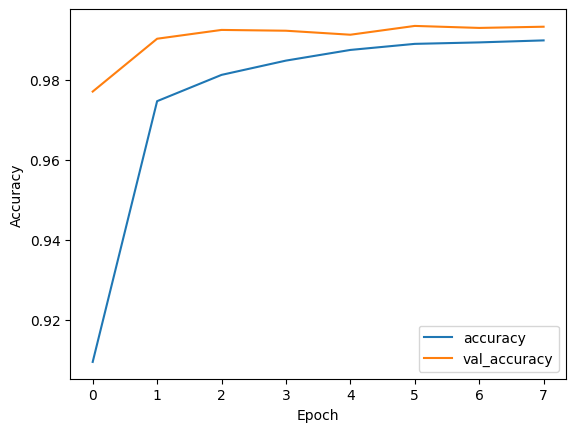

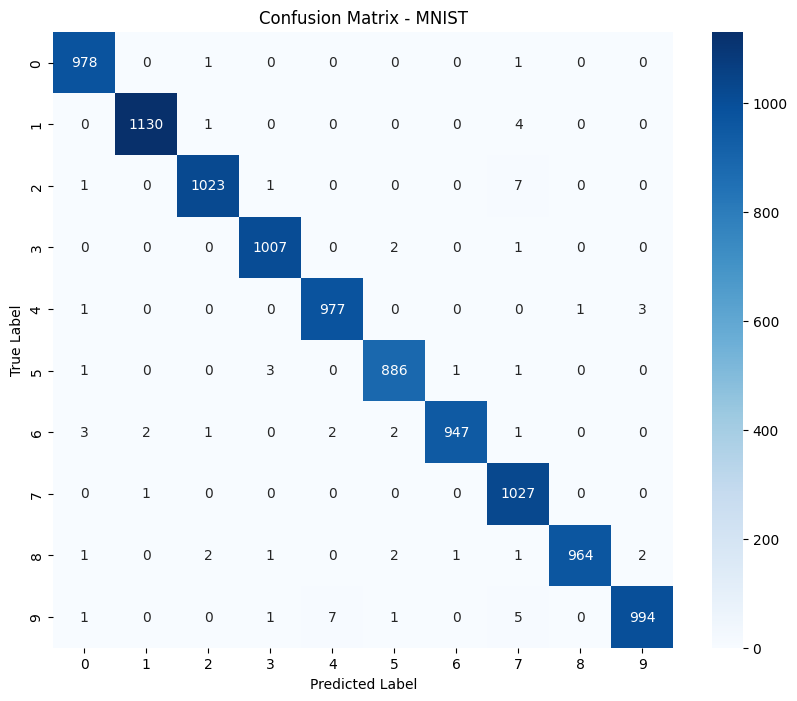


--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0     0.9919    0.9980    0.9949       980
           1     0.9974    0.9956    0.9965      1135
           2     0.9951    0.9913    0.9932      1032
           3     0.9941    0.9970    0.9956      1010
           4     0.9909    0.9949    0.9929       982
           5     0.9922    0.9933    0.9927       892
           6     0.9979    0.9885    0.9932       958
           7     0.9800    0.9990    0.9894      1028
           8     0.9990    0.9897    0.9943       974
           9     0.9950    0.9851    0.9900      1009

    accuracy                         0.9933     10000
   macro avg     0.9933    0.9932    0.9933     10000
weighted avg     0.9933    0.9933    0.9933     10000

Loss graph saved to loss_graph.png


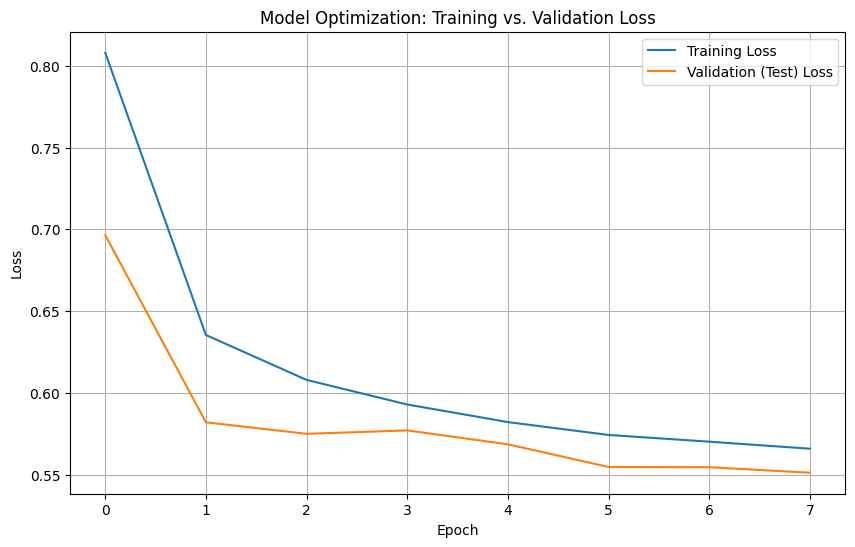

In [5]:

# 9. Visualize Training History (Bonus)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('training_history.png')
print("Training history plot saved.")
# --- ADD THIS TO THE END OF YOUR SCRIPT ---

from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Generating Confusion Matrix...")

# 1. Predict classes on the test set
# The model returns probability arrays (softmax), so we need to convert them to class indices
y_pred_prob = model.predict(x_test) 
y_pred_classes = np.argmax(y_pred_prob, axis=1)


y_true = np.argmax(y_test, axis=1)

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# 4. Plotting using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MNIST')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Save the plot
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved to confusion_matrix.png")
plt.show()


from sklearn.metrics import classification_report

# 1. Classification Report (Precision, Recall, F1-Score)
# This provides the "metrics" for every single digit (0-9)
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true, y_pred_classes, digits=4))

# 2. Visualize Loss (Training vs. Validation)
# Since you passed (x_test, y_test) as validation_data in model.fit, 
# 'val_loss' here represents your Test Loss.
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Optimization: Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)

# Save the plot
plt.savefig('loss_graph.png')
print("Loss graph saved to loss_graph.png")
plt.show()